In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter
from keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input,Dense,Activation
from keras.callbacks import EarlyStopping, TensorBoard
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.grid_search import GridSearchCV

def load_data():
    (x_train, y_train), (x_test, y_test) = imdb.load_data()
    return x_train, y_train, x_test, y_test

def perform_eda(x_train, y_train, x_test, y_test):
    print("EDA RESULTS")
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    print("Min y_train value", y_train.min())
    print("Max y_train value", y_train.max())   
    s = pd.Series(y_train.flatten())
    axes = s.value_counts().sort_index().plot(kind = 'bar')
    axes.set_xlabel('Class')
    axes.set_ylabel('Prevalance')
    axes.set_title('Prevalance for Classes')
    plt.savefig('Class Imbalance.png')
    plt.show()
    print("--------------------------------------------")
    
def assign_var_dict(x_train, y_train, x_test, y_test):   
    var = {}
    var['nb_train'] = x_train.shape[0]
    var['nb_test'] = x_test.shape[0]
    var['nb_classes'] = len(np.unique(y_train))   
    print(var)
    return var

def preprocess_data(x_train, y_train, x_test, y_test, var):
    # indexes to texts
    word2idx = imdb.get_word_index()
    word2idx = {word: idx+3 for word, idx, in word2idx.items()} # +3 offset is crucial
    word2idx['<start>'], word2idx['<oov>'] = 1, 2
    idx2word = {idx: word for word, idx in word2idx.items()}
    # For train set
    word_lists = [[idx2word[idx] for idx in x] for x in x_train]
    texts = [' '.join(word_list) for word_list in word_lists]    
    # texts to BoW
    tok = Tokenizer(10000)
    tok.fit_on_texts(texts)
    x_train = tok.texts_to_matrix(texts)
    # Repeat for test holdout
    word_lists = [[idx2word[idx] for idx in x] for x in x_test]
    texts = [' '.join(word_list) for word_list in word_lists]    
    # texts to BoW
    tok = Tokenizer(10000)
    tok.fit_on_texts(texts)
    x_test = tok.texts_to_matrix(texts)
    # One-Hot Representation for labels
    y_train = to_categorical(y_train, var['nb_classes'])
    y_test = to_categorical(y_test, var['nb_classes'])    
    return x_train, y_train, x_test, y_test

def create_model(var, learn_rate=0.01, momentum=0):
    model = Sequential()
    model.add(Dense(var['nb_classes'],activation='softmax', input_shape = [10000]))
    sgd = SGD(lr=learn_rate, momentum=momentum)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
    #model.summary()
    return model

def train_and_validate_model(model, x_train, y_train, validperc = 0.3, epochval=10, batchsizeval=100):
    # Stop immediately if validation loss reduces
    earlyStopping=EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')
    tbCallBack = TensorBoard(log_dir='./TbGraph', histogram_freq=0, write_graph=True, write_images=True)

    history = model.fit(x_train, 
                       y_train, 
                       epochs=epochval, 
                       batch_size=batchsizeval, 
                       validation_split=validperc,
                       callbacks=[earlyStopping,tbCallBack])
    return history

def evaluate_model(model, x_test, y_test):
    return model.evaluate(x_test, y_test)

def plot_metrics(history, i):    
    # "Accuracy"
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.xticks( range(len(history.history['acc'])))      
    plt.savefig("EpochAcc"+str(i)+".png")
    plt.show()
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.xticks( range(len(history.history['loss']))) 
    plt.savefig("EpochLoss"+str(i)+".png")
    plt.show()
    
def plot_perf_hyperparameter(hyp_metrics):
    # "Loss"
    x_ticks_labels = list(map(itemgetter(2), hyp_metrics))
    plt.plot(list(map(itemgetter(0), hyp_metrics)))
    plt.title('Model Losses')
    plt.ylabel('loss')
    plt.xlabel('hyperparameter')  
    plt.xticks( range(len(x_ticks_labels)), x_ticks_labels )
    plt.savefig("TestLoss.png")
    plt.show()
    # "Accuracy"
    plt.plot(list(map(itemgetter(1), hyp_metrics)))
    plt.title('Model Accuracies')
    plt.ylabel('accuracy')
    plt.xlabel('hyperparameter')
    plt.xticks( range(len(x_ticks_labels)), x_ticks_labels )  
    plt.savefig("TestAcc.png")
    plt.show()
    
def main():
    hyp_metrics = []
    best_model = None
    best_acc = 0.0
    x_train, y_train, x_test, y_test = load_data()
    perform_eda(x_train, y_train, x_test, y_test)
    var = assign_var_dict(x_train, y_train, x_test, y_test) 
    x_train, y_train, x_test, y_test = preprocess_data(x_train, y_train, x_test, y_test, var)
    i = 0
    # Train for 5 data points
    for lr in [0.3, 0.2, 0.1, 0.07, 0.05]:
        i = i+1
        print("--------------------------------------------")
        print ("Hyperparameter SGD Learning Rate:", lr)
        model = None
        model = create_model(var, lr)
        history = train_and_validate_model(model, x_train, y_train)
        plot_metrics(history, i)        
        final_met = evaluate_model(model, x_test, y_test)
        final_met.append(lr)
        hyp_metrics.append(final_met)
        if best_acc < final_met[1]:
            best_model = model
            best_acc = final_met[1]
        print("Final evaluation on test holdout", final_met)

    plot_perf_hyperparameter(hyp_metrics)
    
    # serialize model to JSON
    model_json = best_model.to_json()
    with open("imdb_best.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    best_model.save_weights("imdb_best.h5")  
        
    

Using TensorFlow backend.
/Users/eli/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/eli/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


EDA RESULTS
x_train shape: (25000,)
25000 train samples
25000 test samples
Min y_train value 0
Max y_train value 1


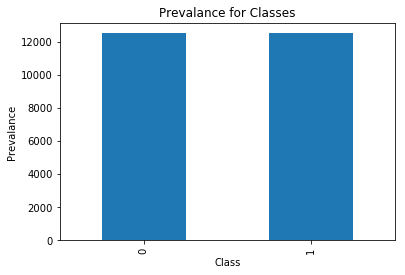

--------------------------------------------
{'nb_train': 25000, 'nb_test': 25000, 'nb_classes': 2}
--------------------------------------------
Hyperparameter SGD Learning Rate: 0.3
Train on 17500 samples, validate on 7500 samples
Epoch 1/10
17500/17500 [==============================] - 6s - loss: 0.6582 - acc: 0.7518 - val_loss: 0.3196 - val_acc: 0.8669

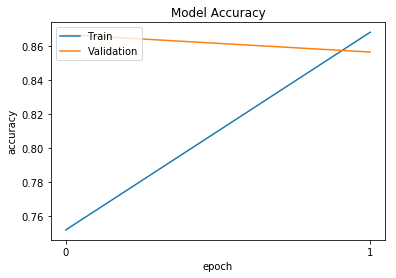

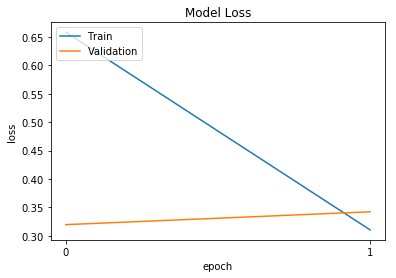

24992/25000 [============================>.] - ETA: 0s 

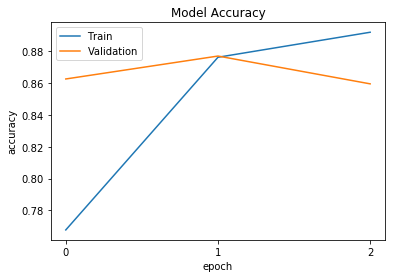

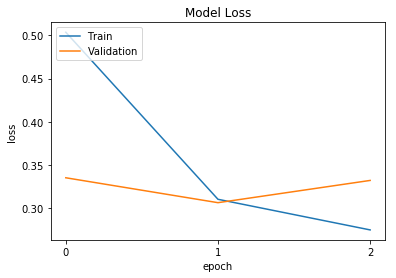

24928/25000 [============================>.] - ETA: 0s 

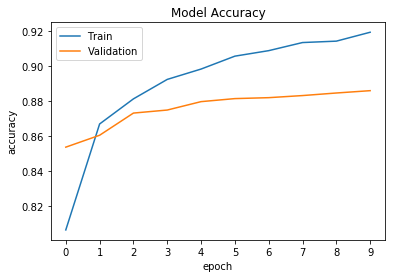

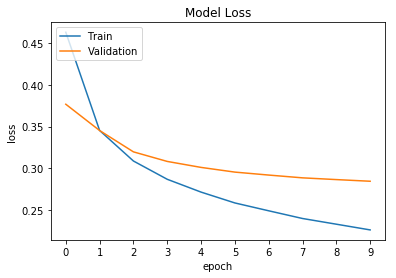

24992/25000 [============================>.] - ETA: 0s

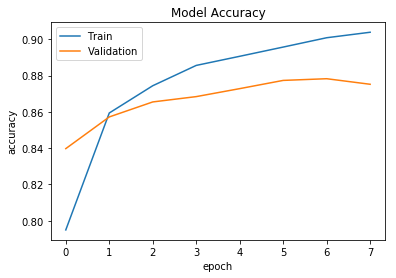

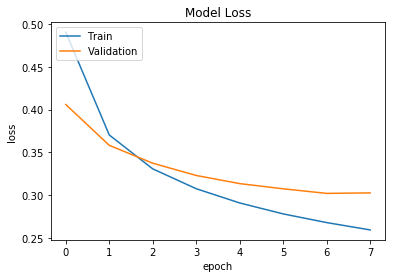

24832/25000 [============================>.] - ETA: 0s

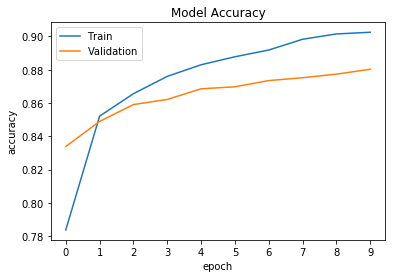

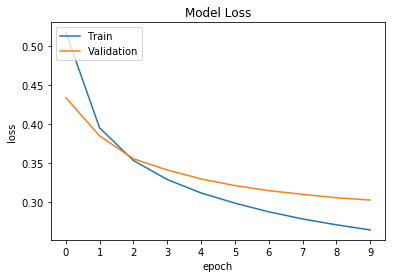

24768/25000 [============================>.] - ETA: 0s

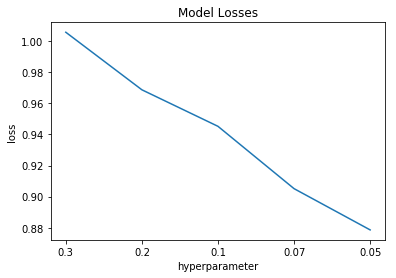

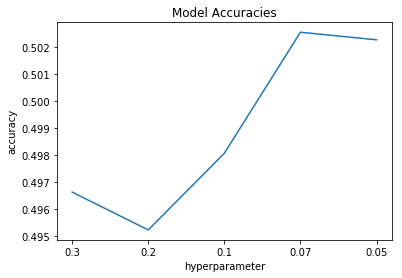

In [2]:
main()

In [3]:
!tensorboard --logdir TbGraph 

/bin/sh: tensorboard: command not found


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter
from keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input,Dense,Activation
from keras.callbacks import EarlyStopping, TensorBoard
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.grid_search import GridSearchCV


(x_train, y_train), (x_test, y_test) = imdb.load_data()
word2idx = imdb.get_word_index()
word2idx = {word: idx+3 for word, idx, in word2idx.items()} # +3 offset is crucial
word2idx['<start>'], word2idx['<oov>'] = 1, 2
idx2word = {idx: word for word, idx in word2idx.items()}
# For train set
word_lists = [[idx2word[idx] for idx in x] for x in x_train]
texts = [' '.join(word_list) for word_list in word_lists]    
# texts to BoW
tok = Tokenizer(10000)
tok.fit_on_texts(texts)
x_train = tok.texts_to_matrix(texts)
word_lists1 = [[idx2word[idx] for idx in x] for x in x_test]
texts1 = [' '.join(word_list) for word_list in word_lists1]    
# texts to BoW
tok1 = Tokenizer(10000)
tok1.fit_on_texts(texts1)
x_test = tok.texts_to_matrix(texts1)

In [7]:
texts[0]

"<start> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and sh

In [8]:
texts1[0]

'<start> how his charter evolved as both man and ape was outstanding not to mention the scenery of the film christopher lambert was astonishing as lord of greystoke christopher is the soul to this masterpiece i became so with his performance i could feel my heart pounding the of the movie still moves me to this day his portrayal of john was oscar worthy as he should have been nominated for it'